# Domain Adaptation on Eurosat Dataset

## 1. Environment Setup

### 1.1 Colab Environment

In [ ]:
## Mounting drive on Colab to access content
from google.colab import drive
drive.mount('/content/gdrive')

## Appending path of GDrive folder to system path to access private modules and files
import sys
sys.path.append('/content/gdrive/MyDrive/ml-mavericks')

Mounted at /content/gdrive


### 1.2 Imports

In [ ]:
## Torch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

## Other DS modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Other modules
from tqdm import tqdm
from datetime import datetime
import h5py
import os

## Private modules
from utils.utils import ForeverDataIterator, EurosatPreloadedDataset, EurosatPreloadedTestset, accuracy, plot_confusion_matrix_dacnn, loss_accuracy_curve_dacnn

### 1.3 Global Variables

In [ ]:
## Path to load training and test data (in .H5 format)
TRAINING_PATH = "/content/gdrive/MyDrive/ml-mavericks/data/trainingset_RGB_NDVI.h5"
TEST_PATH = "/content/gdrive/MyDrive/ml-mavericks/data/testset_RGB_NDVI.h5"

# Path to save models, visualizations, and submisssion
MODEL_PATH = "/content/gdrive/MyDrive/ml-mavericks/models"
VISUALIZATION_PATH = "/content/gdrive/MyDrive/ml-mavericks/visualisation"
SUBMISSION_PATH = "/content/gdrive/MyDrive/ml-mavericks/submissions"

In [ ]:
## Initialization of CLASS_LABELS: list of the 10 land cover types covered in Eurosat 
CLASS_LABELS = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", 
                "Permanent Crop", "Residential", "River", "SeaLake"]

## Initialization of ID2LABEL: dictionary that maps numerical IDs to their corresponding land cover types
ID2LABEL = {0: "AnnualCrop", 1: "Forest", 2: "HerbaceousVegetation", 3: "Highway", 4: "Industrial", 
            5: "Pasture", 6: "PermanentCrop", 7: "Residential", 8: "River", 9: "SeaLake"}

In [ ]:
## Initialization of Torch device to use CUDA for GPU acceleration for faster computation
DEVICE = torch.device("cuda")

## 2. Data Setup

### 2.1 Train-Validation Split

In [ ]:
## Setting the train-validation split ratio to 0.2 (i.e., 80% for training, 20% for validation)
TRAIN_VAL_SPLIT_RATIO = 0.2

In [ ]:
## Creating a list of indices of the training data for train-validation split
with h5py.File(TRAINING_PATH, "r") as f:
    X = list(f['labels'])
    X_indices = [i for i in range(len(X))]

In [ ]:
## Splitting indices into training and validation indices using train_test_split function
## Result indices are used to extract to the corresponding data from the dataset later on
X_train_indices, X_val_indices = train_test_split(X_indices, shuffle=True, random_state=42, test_size=TRAIN_VAL_SPLIT_RATIO)

In [ ]:
## Creating dictionary with the sizes of the training and validation datasets, respectively
dataset_sizes = {"train": len(X_train_indices), "val": len(X_val_indices)}

In [ ]:
## Code to sort the indices of training and validation data (otherwise, it does not run)
X_train_indices.sort()
X_val_indices.sort()

### 2.2 Data Augmentations

In [ ]:
## Setting image transformations for training, validation, and testing 
## Transformations include resizing, rotating, flipping, center cropping

## Transformations for training data
transform_train = transforms.Compose([

        ## Transforming data to tensor
        transforms.ToTensor(),

        # enlarge the images by bilinear interpolation                       
        transforms.Resize([92,92]),                            

        # rotate the picture by the degree input
        transforms.RandomRotation(5),

        # pad the edges by 10 pixels
        transforms.RandomCrop(112, padding = 10),
        
        # normalize
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # given parameters

    ])

## Transformations for validation data
transform_val = transforms.Compose([

        ## Transforming data to tensor
        transforms.ToTensor(),

        # enlarge the images by bilinear interpolation
        transforms.Resize([92,92]),

        # cut the image from the center
        transforms.CenterCrop(112),

        # normalize
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])  

## Transformations for test data
transform_test = transforms.Compose([

        ## Transforming data to tensor
        transforms.ToTensor(),

        # enlarge the images by bilinear interpolation
        transforms.Resize([92,92]),

        # cut the image from the center
        transforms.CenterCrop(112),

        # normalize
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])  

### 2.3 Data Loading

In [ ]:
## Defining batch size for the model training
BATCH_SIZE = 128

In [ ]:
## Loading Eurosat dataset for training, validation, and testing, applying respective transformations
trainset = EurosatPreloadedDataset(root_dir=TRAINING_PATH, transform=transform_train, classes=CLASS_LABELS, indices=X_train_indices)
valset = EurosatPreloadedDataset(root_dir=TRAINING_PATH, transform=transform_val, classes=CLASS_LABELS, indices=X_val_indices)
testset = EurosatPreloadedTestset(root_dir=TEST_PATH, transform=transform_test)

In [ ]:
## Data loaders for training, validation, and testing sets with batch size and shuffling
## Last batch is dropped to ensure that all batches have the same size
train_source_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
train_target_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
# Initialization of two data iterators for the source domain and target domain using the ForeverDataIterator class
# The ForeverDataIterator class ensures that the data iterators never run out of data during training
train_source_iter = ForeverDataIterator(train_source_loader)
train_target_iter = ForeverDataIterator(train_target_loader)

## 3. Model Setup

### 3.1. Model instantiation

In [ ]:
## Setting the Gradient Reversal Function as a static method within a class. The forward pass is a no-op, 
## while the backward pass applies -λ to the gradient. This function is used in neural networks for domain adaptation. 

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, λ):
        ## Store context for backprop
        ctx.λ = λ
        
        ## Forward pass is a no-op
        return x

    @staticmethod
    def backward(ctx, grad_output):
        ## Backward pass is just to apply -λ to the gradient
        output =  - ctx.λ * grad_output

        ## Must return number of inputs to forward()
        return output, None

In [ ]:
## Defining Domain Classifier CNN (DACNN) class, which uses a pre-trained ResNet model as a feature extractor 
## and appends (1) a class classifier & (2) a domain classifier based on the extracted features

class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        ## Loading pre-trained ResNet model and remove the last layer (fully connected layer)
        resnet = models.resnet18(pretrained=True)
        resnet_layers = list(resnet.children())[:-1]
        
        ## Creating the feature extractor using the ResNet layers
        self.feature_extractor = nn.Sequential(*resnet_layers)
        
        ## Changing the input size for the classifiers based on the output of the feature extractor
        self.num_cnn_features = 512
        
        ## Creating class classifier for the classification of the images per land use (10 types)
        self.class_classifier = nn.Sequential(
            nn.Linear(self.num_cnn_features, 10),
            nn.BatchNorm1d(10), nn.ReLU(True),
            nn.LogSoftmax(dim=1),
        )
        
        ## Creating domain classifier for the classification of the images whether domain is source vs. target
        self.domain_classifier = nn.Sequential(
            nn.Linear(self.num_cnn_features, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Linear(20, 2),
            nn.LogSoftmax(dim=1)
        )
        
    ## Standard forward pass to return the prediction on class and domain
    def forward(self, x, λ=1.0):
        features = self.feature_extractor(x)
        features = features.view(-1, self.num_cnn_features)

        ## Predicting domain classification
        features_grl = GradientReversalFn.apply(features, λ)
        domain_pred = self.domain_classifier(features_grl)  # classify on features after GRL
        
        ## Predicting class classification
        class_pred = self.class_classifier(features)        # classify on regular features
        
        return class_pred, domain_pred

In [ ]:
## Initializing DACNN model and setting it to DEVICE
model = DACNN()
model.to(DEVICE)

### 3.2 Model hyperparameters

In [ ]:
## Setting um learning rate (lr) and momentum
lr = 1e-3
momentum = 0.9

# Defining optimizer to SGD
optimizer = optim.SGD(model.parameters(), lr, momentum)

# Defining two loss functions for class and domain classifier, respectively
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()

In [ ]:
## Number of epochs for training the model
epochs = 20

## Number of iterations (batches) per epoch 
iterations = len(train_source_loader) * 1

## 4. Training & Evaluation

### 4.1 Model Training

In [ ]:
## Setting formatted_now for tractability
formatted_now = datetime.now().strftime("%Y%m%d_%H%M%S")

## Setting accuracy tracker for classifier, source, target & evaluation accuracy
tracker_accuracy_classifier = []
tracker_accuracy_source = []
tracker_accuracy_target = []
tracker_accuracy_evaluation = []

## Setting loss tracker for classifier, source, target and evaluation loss
tracker_losses_classifier = []
tracker_losses_source = []
tracker_losses_target = []
tracker_losses_evaluation = []

## Beginning of model training loop - by epoch
for epoch_idx in range(epochs): 

    ## Printing epoch number
    print(f'Epoch {epoch_idx+1:04d} / {epochs:04d}', end='\n=================\n')

    ## Looping over phases: training and validation, respectively
    for phase in ["train", "val"]:
        if phase == "train":
            
            ## Setting model to training and activating gradients for all parameters
            model.train()

            for param in model.parameters():
              param.requires_grad = True

            ## Initalizing running_accuracy (for epoch) for classifier, source and domain accuracy
            running_accuracy_classifier = 0
            running_accuracy_source = 0
            running_accuracy_target = 0

            ## Initalizing running_loss (for epoch) for classifier, source and domain loss
            running_loss_classifier = 0
            running_loss_source = 0
            running_loss_target = 0
            
            ## Looking over number of iterations (i.e., number of batches in train)
            for batch_idx in range(iterations):      
        
                ## Calculate training progress and the λ for the gradient reversal layer
                p = float(batch_idx + epoch_idx * iterations) / (epochs * iterations)
                # λ = 2. / (1. + np.exp(-10 * p)) - 1
                λ = 0.2

                ## Included to skip classifier training every second epoch
                if epoch_idx % 2 == 0:

                  ## Classifier
                  X_s, y_s = next(train_source_iter)
                  X_s, y_s = X_s.to(DEVICE), y_s.to(DEVICE)
                  
                  class_pred, _ = model(X_s, λ)
                  loss_s_label = loss_fn_class(class_pred, y_s)

                  running_accuracy_classifier += accuracy(class_pred, y_s)
                  running_loss_classifier += loss_s_label.item()

                ## Discriminator  
                  
                ## On source domain 
                X_s, y_s = next(train_source_iter)
                X_s, y_s = X_s.to(DEVICE), y_s.to(DEVICE) 
                y_s_domain = torch.zeros(BATCH_SIZE, dtype=torch.long).to(DEVICE)
              
                _, domain_pred_source = model(X_s, λ)
                loss_s_domain = loss_fn_domain(domain_pred_source, y_s_domain)
              
                running_accuracy_source += accuracy(domain_pred_source, y_s_domain)
                running_loss_source += loss_s_domain.item()
              
                ## On target domain 
                X_t, _ = next(train_target_iter)
                X_t = X_t.to(DEVICE) 
                y_t_domain = torch.ones(BATCH_SIZE, dtype=torch.long).to(DEVICE) 
              
                _, domain_pred_target = model(X_t, λ)
                loss_t_domain = loss_fn_domain(domain_pred_target, y_t_domain)

                running_accuracy_target += accuracy(domain_pred_target, y_t_domain)
                running_loss_target += loss_t_domain.item()

                ## Calculating the total loss - including 
                if epoch_idx % 2 == 0:
                  loss = loss_t_domain + loss_s_domain + loss_s_label
                else: 
                  loss = loss_t_domain + loss_s_domain

                ## Updating gradient & backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            ## Calculating accuracy for classifier & adding to tracker
            accuracy_classifier = running_accuracy_classifier / (BATCH_SIZE*iterations)
            tracker_accuracy_classifier.append(accuracy_classifier)

            ## Calculating accuracy for source & adding to tracker
            accuracy_source = running_accuracy_source / (BATCH_SIZE*iterations)
            tracker_accuracy_source.append(accuracy_source)

            ## Calculating accuracy for target & adding to tracker
            accuracy_target = running_accuracy_target / (BATCH_SIZE*iterations)
            tracker_accuracy_target.append(accuracy_target)

            ## Calculating loss for classifier & adding to tracker
            loss_classifier = running_loss_classifier / iterations
            tracker_losses_classifier.append(loss_classifier)

            ## Calculating loss for source & adding to tracker
            loss_source = running_loss_source / iterations
            tracker_losses_source.append(loss_source)

            ## Calculating loss for target & adding to tracker
            loss_target = running_loss_target / iterations
            tracker_losses_target.append(loss_target)

            ## Printing out Lambda, accuracies and losses
            print(f'Lambda end of epoch: {λ}\n\n'
                  f'Classifier Accuracy: {accuracy_classifier}\n'
                  f'Source Accuracy: {accuracy_source}\n'
                  f'Target Accuracy: {accuracy_target}\n\n'
                  f'Loss Classifier: {loss_classifier}\n'
                  f'Loss Source: {loss_source}\n'
                  f'Loss Target: {loss_target}\n\n')
        
        ## Looking in validation phase
        if phase == "val":

            ## Setting model to eval & disabling gradients
            model.eval()
            
            for param in model.parameters():
              param.requires_grad = False

            ## Initalizing running accuracy & loss (per epoch) for evaluation
            running_accuracy_evaluation = 0
            running_loss_evaluation = 0

            ## Iterating through val_loader to get predictions
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                preds, _ = model(inputs)
                loss_e_source = loss_fn_class(preds, labels)
                
                running_accuracy_evaluation += accuracy(preds, labels)
                running_loss_evaluation += loss_e_source.item()

            ## Calculating total accuracy and loss for evaluation & adding to tracker
            accuracy_evaluation = running_accuracy_evaluation / (len(val_loader) * BATCH_SIZE)
            loss_evaluation = running_loss_evaluation / len(val_loader)

            tracker_accuracy_evaluation.append(accuracy_evaluation)
            tracker_losses_evaluation.append(loss_evaluation)
            
            ## Printing accuracy and loss for evaluation
            print(f'Evaluation Accuracy: {accuracy_evaluation}\n'
                  f'Evaluation Loss: {loss_evaluation}\n')
    
    ## Saving the model
    torch.save(model.state_dict(), os.path.join(MODEL_PATH, f'DACNN_{formatted_now}_{epoch_idx+1}.pth'))

### 4.2 Model selection


In [ ]:
## Creating path for selected model based on epoch & formatted_now for further evaluation 
chosen_epoch = 19
chosen_model = os.path.join(MODEL_PATH, f'DACNN_{formatted_now}_{chosen_epoch}.pth')

In [ ]:
## Loading weights of chosen model and assigning them to the model's state dictionary
model_weights = torch.load(chosen_model)
model.load_state_dict(model_weights)

<All keys matched successfully>

### 4.3 Evaluation

100%|██████████| 5400/5400 [00:26<00:00, 202.26it/s]


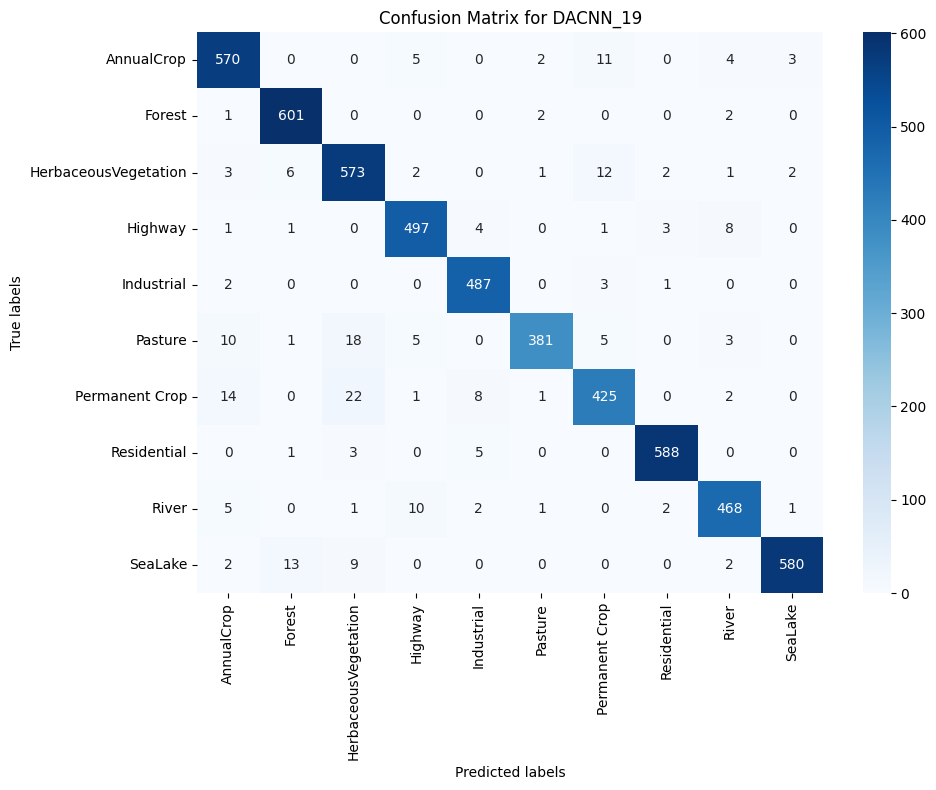

In [ ]:
## Plotting the confusion matrix based on the chosen model & the valuation set
image_path_cm = os.path.join(VISUALIZATION_PATH, f'DACNN_{formatted_now}_{chosen_epoch}_confusion_matrix.jpg')
plot_confusion_matrix_dacnn(model=model, valset=valset, class_names=CLASS_LABELS, model_name = f'DACNN_{chosen_epoch}', image_path=image_path_cm, device=DEVICE)

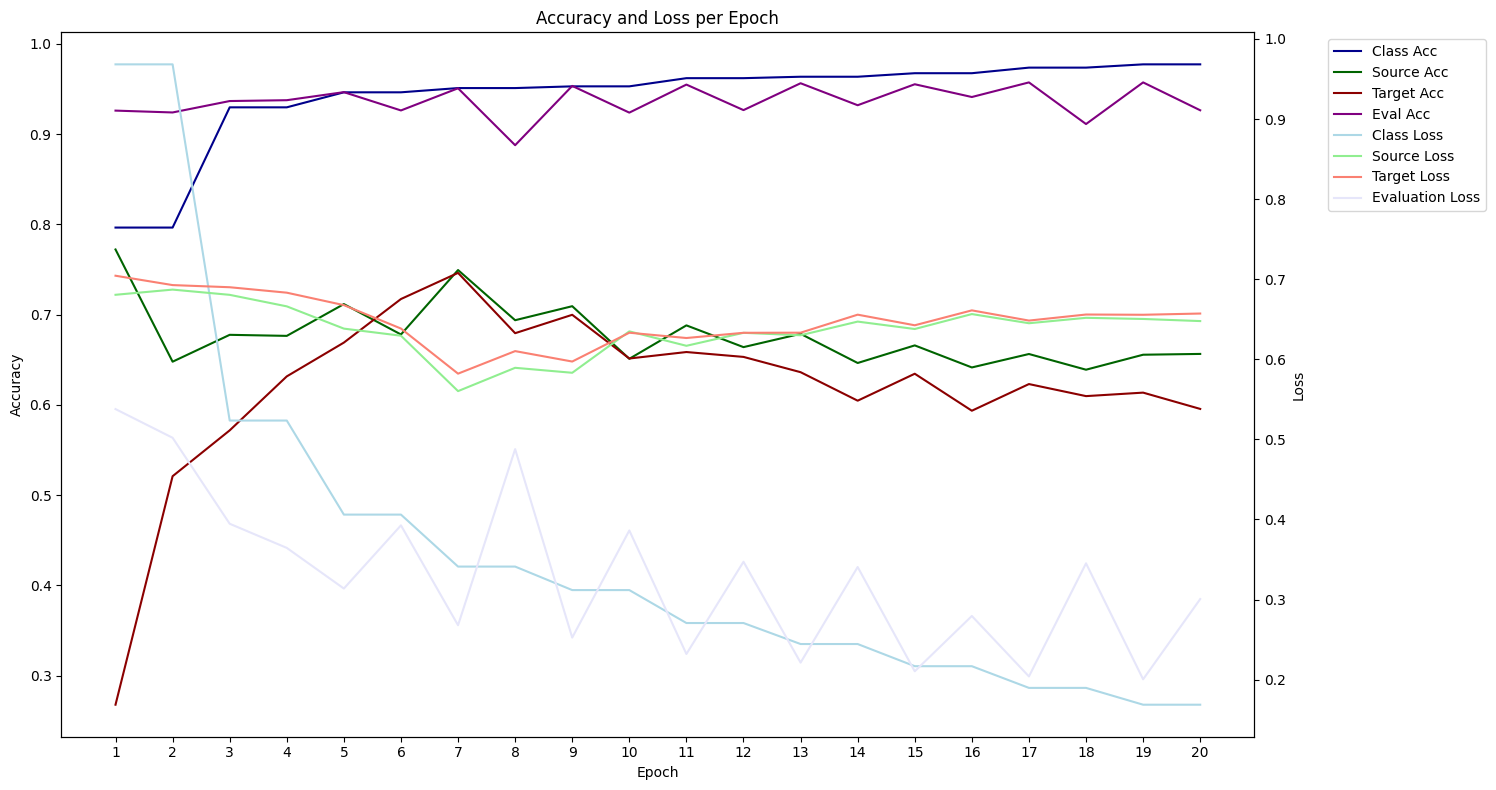

<Figure size 640x480 with 0 Axes>

In [ ]:
## Plotting the learning curve based on the chosen model & the valuation set
image_path_lc = os.path.join(VISUALIZATION_PATH, f'DACNN_{formatted_now}_learning_curve.jpg')
loss_accuracy_curve_dacnn(acc_class = tracker_accuracy_classifier, 
                    acc_source = tracker_accuracy_source, 
                    acc_target = tracker_accuracy_target, 
                    acc_eval = tracker_accuracy_evaluation, 
                    loss_class = tracker_losses_classifier, 
                    loss_source = tracker_losses_source, 
                    loss_target = tracker_losses_target, 
                    loss_eval = tracker_losses_evaluation,
                    image_path = image_path_lc)

## 5.0 Inferece

### 5.1 Inference on Test Data

In [ ]:
## Setting model to evaluation and deactivting gradients for all parameters
model.eval()
for param in model.parameters():
  param.requires_grad = False

In [ ]:
## Predicting with chosen_model on test data - results are appended to list

predicted_results = []

for i in tqdm(range(len(testset))):
    
    ## Choosing sample to be evaluated
    sample = testset[i][0].to(DEVICE)
    
    ## Predicting class of sample based on chosen model
    output, _ = model(sample.unsqueeze(0))
    _, predicted = torch.max(output, 1)
    
    ## Translating ID to land use label
    predicted_group = ID2LABEL[predicted.item()]
    testid = int(testset[i][1])
    
    ## Appending label and ID to list
    predicted_results.append((testid, predicted_group))

### 5.2 Submission File

In [ ]:
## Creating submission file based on predictions in 5.1 
submission = pd.DataFrame(predicted_results, columns=["test_id", "label"])
submission = submission.sort_values("test_id")
submission.to_csv(os.path.join(SUBMISSION_PATH, f'DACNN_{formatted_now}_{chosen_epoch}_submission.csv'), index=False)

## Final Remark

Part of this notebook is based on the tutorial by Prof. Bronstein on Domain Adaptation, which can be accessed under the following [link](https://www.youtube.com/watch?v=MIsSuWsZtKE). 